##Model

In [ ]:
import torch
import torch.nn as nn

class Tiny10(nn.Module):
    def __init__(self, num_classes=10):
        super(Tiny10, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



In [ ]:
if torch.cuda.is_available():
     torch.set_default_tensor_type(torch.cuda.FloatTensor)
     print('yes')

yes


##Train and Test

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0,  generator=torch.Generator(device='cuda'),)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=0,  generator=torch.Generator(device='cuda'),)

model = Tiny10().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# TODO: cosine scheduler for lr
num_epochs = 20

for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    running_loss = 0.0

    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}")
            running_loss = 0.0

    # Validation
    model.eval()  # Set model to evaluation mode

    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    accuracy_teacher = 100 * total_correct / total_samples
    print(f"Accuracy on the test set: {accuracy_teacher:.2f}%")

# End of training loop


100%|██████████| 170498071/170498071 [00:14<00:00, 11730859.17it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[Epoch 1, Batch 100] Loss: 1.862
[Epoch 1, Batch 200] Loss: 1.595
[Epoch 1, Batch 300] Loss: 1.430
Accuracy on the test set: 52.06%
[Epoch 2, Batch 100] Loss: 1.245
[Epoch 2, Batch 200] Loss: 1.196
[Epoch 2, Batch 300] Loss: 1.148
Accuracy on the test set: 58.41%
[Epoch 3, Batch 100] Loss: 1.084
[Epoch 3, Batch 200] Loss: 1.067
[Epoch 3, Batch 300] Loss: 1.031
Accuracy on the test set: 60.53%
[Epoch 4, Batch 100] Loss: 0.989
[Epoch 4, Batch 200] Loss: 0.979
[Epoch 4, Batch 300] Loss: 0.957
Accuracy on the test set: 64.81%
[Epoch 5, Batch 100] Loss: 0.930
[Epoch 5, Batch 200] Loss: 0.925
[Epoch 5, Batch 300] Loss: 0.891
Accuracy on the test set: 65.86%
[Epoch 6, Batch 100] Loss: 0.865
[Epoch 6, Batch 200] Loss: 0.866
[Epoch 6, Batch 300] Loss: 0.856
Accuracy on the test set: 68.29%
[Epoch 7, Batch 100] Loss: 0.836
[Epoch 7, Batch 200] Loss: 0.819
[Epoch 7, Batch 300] Loss: 0.805
Accuracy on the test

##CKA

In [ ]:
def unbiased_HSIC(K, L):
  
  n = K.shape[0]
  ones = torch.ones((n,1))

  k_t = K.fill_diagonal_(0) 
  l_t = L.fill_diagonal_(0) 
  temp = torch.matmul(k_t.clone(), l_t.clone())

  trace = torch.trace(temp)

  nominator1 = torch.matmul(torch.matmul(torch.reshape(ones,(1,-1)), k_t), ones)

  nominator2 = torch.matmul(torch.matmul(torch.reshape(ones,(1,-1)), l_t), ones)

  denominator = (n-1)*(n-2)
  middle = torch.matmul(nominator1, nominator2) / denominator


  multiplier1 = 2/(n-2)
  multiplier2 = torch.matmul(torch.matmul(torch.reshape(ones,(1,-1)), temp),  ones)
  last = multiplier1 * multiplier2

  unbiased_hsic = 1/(n*(n-3)) * (trace + middle - last)

  return unbiased_hsic

Implement CKA for both RBF and Linear Kernels

In [ ]:
def CKA_unbiased(X, Y, f = None):

  
  #Linear Kernel
  X_t = torch.transpose(X,0,1)
  Y_t = torch.transpose(Y,0,1)
  X_gram = torch.matmul(X, X_t)
  Y_gram = torch.matmul(Y, Y_t)

  nominator = unbiased_HSIC(X_gram, Y_gram)
  denominator1 = unbiased_HSIC(X_gram, X_gram)
  denominator2 = unbiased_HSIC(Y_gram, Y_gram)

  # RBF kernel

  # dist_x = torch.pow(torch.cdist(X, X, p=2), 2)
  # dist_y = torch.pow(torch.cdist(Y, Y, p=2), 2)
  # m_x = torch.median(dist_x)
  # m_y = torch.median(dist_y)
  # k = torch.exp(-dist_x/(2*m_x*f*f))
  # l = torch.exp(-dist_y/(2*m_y*f*f))
  # nominator = unbiased_HSIC(k, l)
  # denominator1 = unbiased_HSIC(k, k)
  # denominator2 = unbiased_HSIC(l, l)






  return nominator, denominator1, denominator2

In [ ]:
def calculate_CKA_for_two_matrices(activationA, activationB):

 
  #unfold the activations, that is make a (n, h*w*c) representation
  shape = activationA.shape
  if len(shape)<4:
     activationA = torch.reshape(activationA, (shape[0], shape[1]))
  else:
     activationA = torch.reshape(activationA, (shape[0], shape[1]*shape[2]*shape[3]))

  shape = activationB.shape
  if len(shape)<4:
     activationB = torch.reshape(activationB, (shape[0], shape[1]))
  else:
     activationB = torch.reshape(activationB, (shape[0], shape[1]*shape[2]*shape[3]))

  #calculate the CKA score
  cka_score = CKA_unbiased(activationA, activationB)

  return cka_score

In [ ]:
activation = {}
def get_activation(name):
    global activation
    def hook(model, input, output):
           
            activation[name] = output


    return hook




def get_all_layer_outputs_fn(model):
    global activation
    names = ['features.0','features.3','features.6','features.9','features.12','features.15','features.18', 'classifier']
    for name, module in model.named_modules():
        if name in names:
            module.register_forward_hook(get_activation(name))




In [ ]:
def compare_activations_batch(intermediate_outputs):
 
  for i in range(len(intermediate_outputs)):
        for j in range(len(intermediate_outputs)):
            cka_score = calculate_CKA_for_two_matrices(intermediate_outputs[i], intermediate_outputs[j])
            result_array[i, j] = cka_score[0]/torch.sqrt(cka_score[1]*cka_score[2])
  return result_array


In [ ]:
import matplotlib.pyplot as plt
def cka_plt(mat, name):
  plt.figure(figsize=(2, 2), dpi=200)
  axes = plt.imshow(mat.cpu().numpy(), cmap='magma', vmin=0.0,vmax=1.0)
  axes.axes.invert_yaxis()
  plt.savefig(f"/content/{name}.png", dpi=400)



##CKA Engineering 

Train a new model having similar pattern with pre-defined pattern

[Epoch 1, Batch 100] Loss: 4.124
[Epoch 1, Batch 200] Loss: 3.277
[Epoch 1, Batch 300] Loss: 3.042
Accuracy on the test set: 30.32%
[Epoch 2, Batch 100] Loss: 2.873
[Epoch 2, Batch 200] Loss: 2.826
[Epoch 2, Batch 300] Loss: 2.803
Accuracy on the test set: 59.52%
[Epoch 3, Batch 100] Loss: 2.733
[Epoch 3, Batch 200] Loss: 2.701
[Epoch 3, Batch 300] Loss: 2.695
Accuracy on the test set: 63.23%
[Epoch 4, Batch 100] Loss: 2.649
[Epoch 4, Batch 200] Loss: 2.637
[Epoch 4, Batch 300] Loss: 2.648
Accuracy on the test set: 66.15%
[Epoch 5, Batch 100] Loss: 2.537
[Epoch 5, Batch 200] Loss: 2.618
[Epoch 5, Batch 300] Loss: 2.569
Accuracy on the test set: 63.52%
[Epoch 6, Batch 100] Loss: 2.559
[Epoch 6, Batch 200] Loss: 2.523
[Epoch 6, Batch 300] Loss: 2.545
Accuracy on the test set: 67.02%
[Epoch 7, Batch 100] Loss: 2.511
[Epoch 7, Batch 200] Loss: 2.510
[Epoch 7, Batch 300] Loss: 2.462
Accuracy on the test set: 70.49%
[Epoch 8, Batch 100] Loss: 2.460
[Epoch 8, Batch 200] Loss: 2.543
[Epoch 8, 

KeyboardInterrupt: ignored

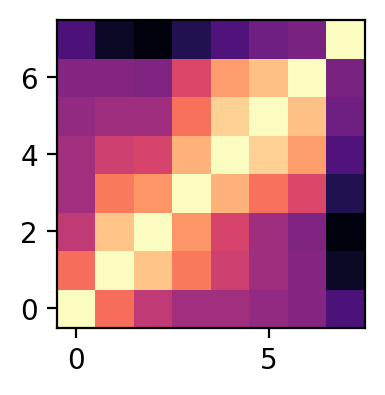

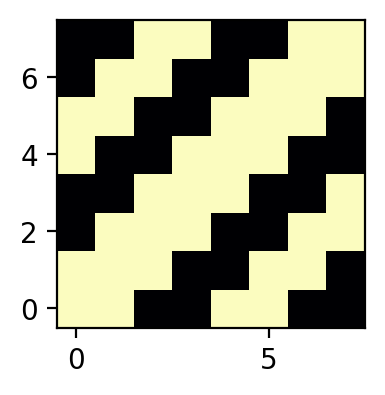

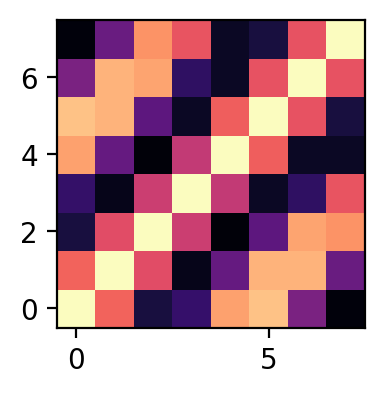

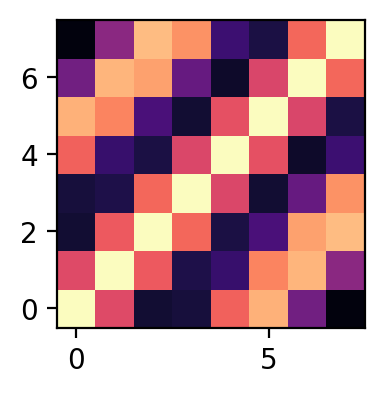

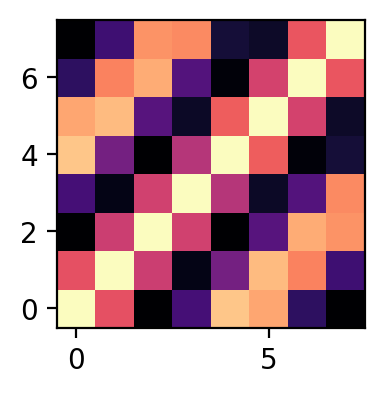

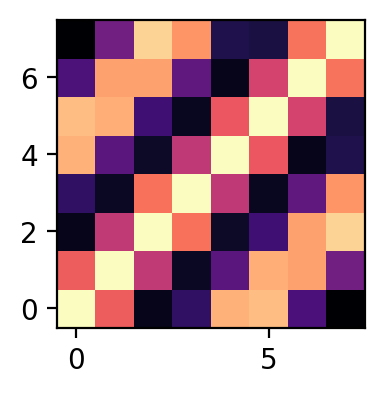

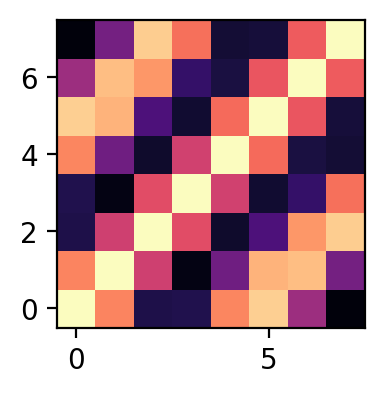

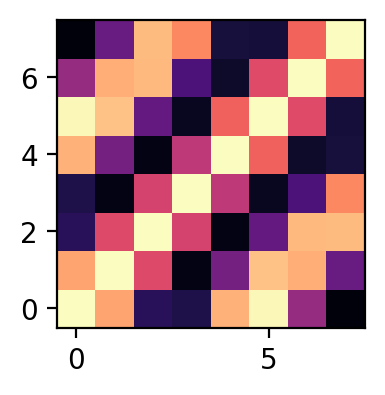

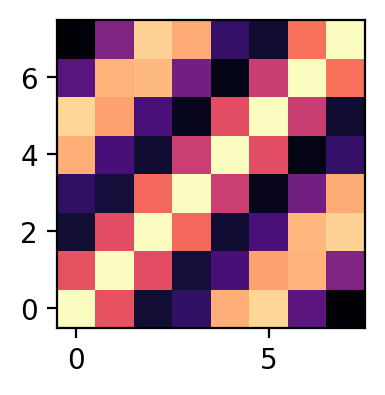

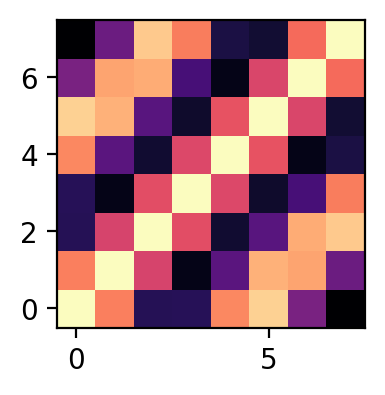

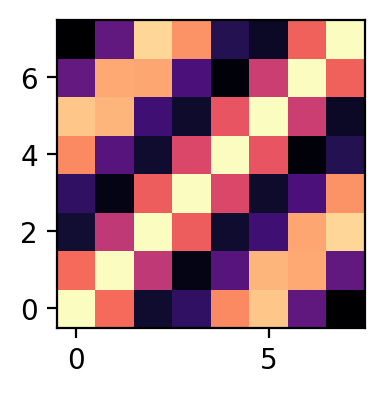

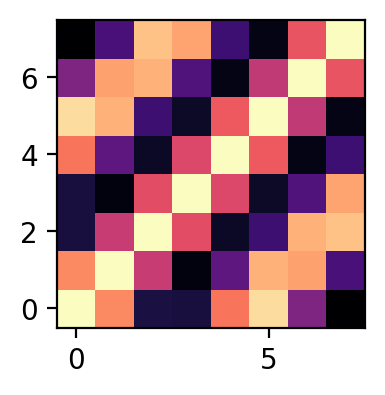

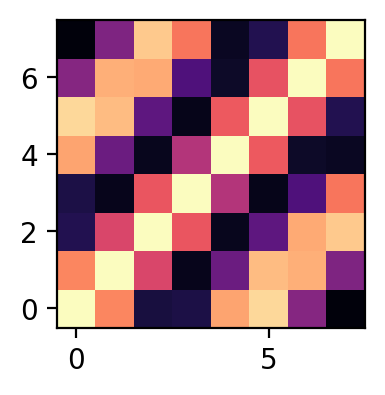

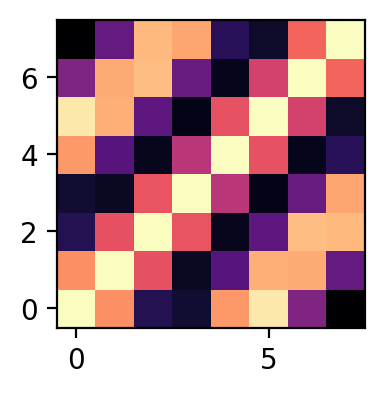

In [ ]:

#CKA Engineering

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from copy import deepcopy


with torch.no_grad():
    teacher_activation = get_all_layer_outputs_fn(model)
    model(next(iter(trainloader))[0].to(device))
    cka_plt(compare_activations_batch(list(activation.values())),'teacher')



student_model = Tiny10().to(device)
student_model.load_state_dict(deepcopy(model.state_dict()))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=0.01)

num_epochs = 10 
l = 1
etha = 0.8
threshold = 4
targetmap = torch.tensor([ [1,1,0,0,1,1,0,0],
                           [1,1,1,0,0,1,1,0],
                           [0,1,1,1,0,0,1,1],
                           [0,0,1,1,1,0,0,1],
                           [1,0,0,1,1,1,0,0],
                           [1,1,0,0,1,1,1,0],
                           [0,1,1,0,0,1,1,1],
                           [0,0,1,1,0,0,1,1]])
cka_plt(targetmap, 'target')



def set_lambda(etha, acc_teacher, acc_student, l, threshold):
  d = acc_teacher - acc_student
  return etha * l if d > threshold else l/etha

for epoch in range(num_epochs):
    student_model.train()
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

       
        get_all_layer_outputs_fn(student_model)

        student_outputs = student_model(inputs)
        student_layers = list(activation.values())

       
        classification_loss = criterion(student_outputs, labels)


        ckamap = compare_activations_batch(student_layers)
        map_loss = torch.sum(torch.log(torch.cosh(ckamap - targetmap)))


        # Total loss as a combination of distillation and classification losses
        loss = l * map_loss + classification_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}")


            running_loss = 0.0

    student_model.eval()  
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = student_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
        cka_plt(ckamap.clone(), str(epoch+1)+':'+str(i))

    accuracy = 100 * total_correct / total_samples

    print(f"Accuracy on the test set: {accuracy:.2f}%")

